https://arxiv.org/pdf/1511.06434.pdf

https://www.tensorflow.org/tutorials/generative/dcgan

https://www.machinecurve.com/index.php/2021/07/15/creating-dcgan-with-tensorflow-2-and-keras/


 Importing  libraries

In [2]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

We are loading fashion mnist data .The generator will generate fashion items resembling the fashion MNIST data.

In [3]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape

4431872/4422102 [==============================] - 0s 0us/step


(60000, 28, 28)

 Reshaping the images to add one more dimension i.e Channel. As the images are gray-scale so Channel dimension will be 1. Also,Normalizing the images to [-1, 1]because the generator’s final layer activation uses tanh

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  

In [5]:
train_images.shape

(60000, 28, 28, 1)

Training set is prepared by dividing the whole data into batches and shuffling it.

In [6]:
buffer_size = 60000
batch_size = 32

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size ).batch(batch_size)

Both the generator and discriminator are defined using the Keras Sequential API.

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28X28x1. Notice the tf.keras.layers.ReLU activation for each layer, except the output layer which uses tanh.

Blocks 2, 3 consist of a convolution transpose(upsampling) layer, followed by a batch-normalization layer and an activation function, ReLU. 
The last block comprises no batch-normalization layer, with a sigmoid activation function. 

Note that activation in final layer is tanh which outputs in the range -1 to 1.Code for GAN architecture is based on this link https://www.tensorflow.org/tutorials/generative/dcgan and the original paper link on  which architecture is based is here-https://arxiv.org/pdf/1511.06434.pdf

In [8]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, input_shape = (100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
   
    model.add(layers.Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', activation = 'tanh'))
    
    return model

Building the generator model and summary is obtained

In [9]:
generator = generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

Using the (as yet untrained) generator to create an random colored image.

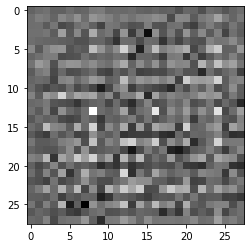

In [10]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')

The discriminator is a CNN-based image classifier.
Inputs an image of dimension 28 X 28 X 1
Outputs a score between 0 and 1(sigmoid activation in final layer)
Batch normalisation layer is applied for intermediate layers
Has Leaky-Relu (with a slope of 0.2) as an activation function in the intermediate layers along with dropout layers
Has a Sigmoid activation function in the output layer.Note that we can also leave the last layer without sigmoid activation and use_logits=True in Binary Cross entropy function(which is recommended but we have done it this way  for ease in calculating real and fake scores with their display)

In [11]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), padding = 'same',
                            input_shape = [28, 28, 1]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

Building the discriminator model and summary is obtained

In [12]:
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                      

Here We are using  the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output values > 0.5  for real images, and values <0.5 for fake images.

In [13]:
discriminator = discriminator_model()
output = discriminator(generated_image)
print (output)

tf.Tensor([[0.49989942]], shape=(1, 1), dtype=float32)


Now We are defining loss functions. In this case it is Binary Cross entropy as target is real or fake images

In [14]:
bce = tf.keras.losses.BinaryCrossentropy()

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    
    return total_loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [16]:
def generator_loss(fake_output):
    gen_loss = bce(tf.ones_like(fake_output), fake_output)
    
    return gen_loss

The discriminator and the generator optimizers are different since  two networks would be trained separately.

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

Following code demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

We are using `tf.function`
This annotation causes the function to be "compiled".


In [19]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

Notice `training` is set to False.
This is so all layers run in inference mode (batchnorm).
Function for generating and saving images is defined

In [20]:
def generate_and_plot_images(model, epoch, test_input):
  
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (8, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  
        pred = (predictions[i, :, :, 0] + 1) * 127.5  
        pred = np.array(pred)    
        plt.imshow(pred.astype(np.uint8), cmap = 'gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [21]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

In [22]:
def train(dataset, epochs):
    
    gen_loss_list = []
    disc_loss_list = []
    
    real_score_list = []
    fake_score_list = []
    
    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)
        
        print(f'Training started with  epoch {epoch + 1} with {num_batches} batches..')
        
        total_gen_loss = 0
        total_disc_loss = 0
        
        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss
        
        mean_gen_loss = total_gen_loss/num_batches
        mean_disc_loss = total_disc_loss/num_batches
           
        print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score %.2f%%, fake_score %.2f%%' %
              (epoch + 1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        generate_and_plot_images(generator, epoch + 1, seed)         

        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        if (epoch + 1) % 10 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  
    return  gen_loss_list, disc_loss_list, real_score_list, fake_score_list              

Finally, it’s time to train our  GAN model in Tensorflow. Taking the train_dataset and epochs as the parameters, the  train function calls the train_step function, at every new batch.At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look more real. 

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with  epoch 1 with 1875 batches..
Losses after epoch     1: generator 1.492, discriminator 0.773, real_score 80.75%, fake_score 32.65%


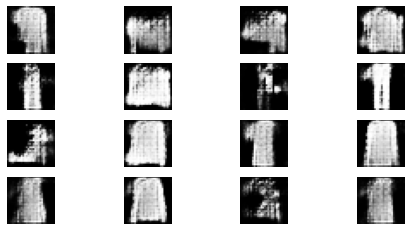

  2%|▏         | 1/50 [00:16<13:44, 16.82s/it]

Time for epoch 1 is 16.824223041534424 sec
Training started with  epoch 2 with 1875 batches..
Losses after epoch     2: generator 1.015, discriminator 1.150, real_score 63.69%, fake_score 42.22%


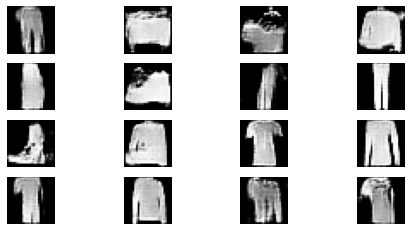

  4%|▍         | 2/50 [00:30<12:10, 15.22s/it]

Time for epoch 2 is 14.096433877944946 sec
Training started with  epoch 3 with 1875 batches..
Losses after epoch     3: generator 0.999, discriminator 1.393, real_score 52.09%, fake_score 43.38%


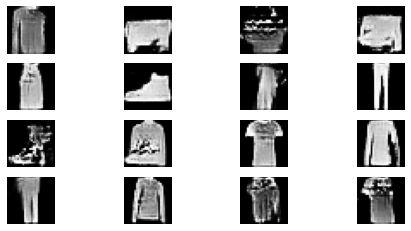

  6%|▌         | 3/50 [00:44<11:29, 14.68s/it]

Time for epoch 3 is 14.015672445297241 sec
Training started with  epoch 4 with 1875 batches..
Losses after epoch     4: generator 0.806, discriminator 1.235, real_score 64.16%, fake_score 49.17%


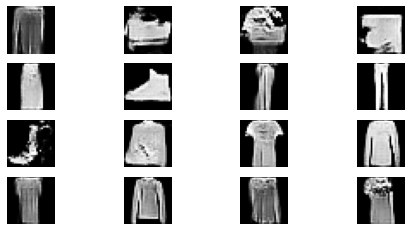

  8%|▊         | 4/50 [00:59<11:08, 14.52s/it]

Time for epoch 4 is 14.277415752410889 sec
Training started with  epoch 5 with 1875 batches..
Losses after epoch     5: generator 0.989, discriminator 1.374, real_score 47.95%, fake_score 40.05%


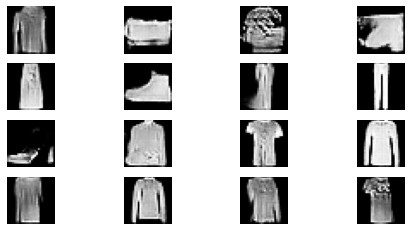

 10%|█         | 5/50 [01:14<10:57, 14.61s/it]

Time for epoch 5 is 14.762416362762451 sec
Training started with  epoch 6 with 1875 batches..
Losses after epoch     6: generator 0.672, discriminator 1.513, real_score 55.88%, fake_score 54.25%


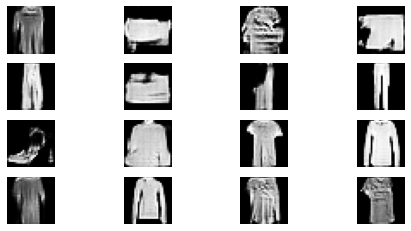

 12%|█▏        | 6/50 [01:29<10:56, 14.91s/it]

Time for epoch 6 is 15.476670742034912 sec
Training started with  epoch 7 with 1875 batches..
Losses after epoch     7: generator 0.861, discriminator 1.332, real_score 52.26%, fake_score 45.19%


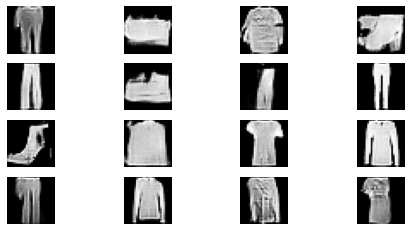

 14%|█▍        | 7/50 [01:44<10:43, 14.95s/it]

Time for epoch 7 is 15.03581976890564 sec
Training started with  epoch 8 with 1875 batches..
Losses after epoch     8: generator 1.014, discriminator 1.285, real_score 52.13%, fake_score 38.96%


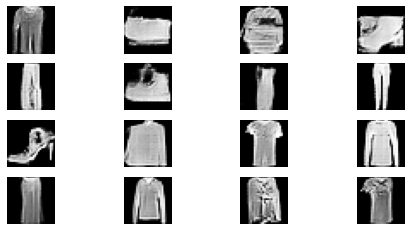

 16%|█▌        | 8/50 [01:59<10:26, 14.91s/it]

Time for epoch 8 is 14.820733547210693 sec
Training started with  epoch 9 with 1875 batches..
Losses after epoch     9: generator 0.995, discriminator 1.290, real_score 50.56%, fake_score 40.44%


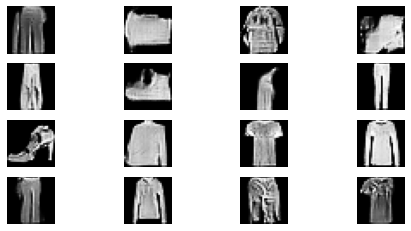

 18%|█▊        | 9/50 [02:14<10:11, 14.91s/it]

Time for epoch 9 is 14.917327880859375 sec
Training started with  epoch 10 with 1875 batches..
Losses after epoch    10: generator 0.943, discriminator 1.294, real_score 52.01%, fake_score 41.43%


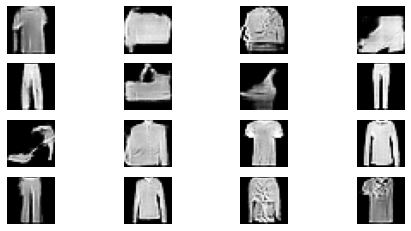

 20%|██        | 10/50 [02:29<09:55, 14.88s/it]

Time for epoch 10 is 14.807238578796387 sec
Training started with  epoch 11 with 1875 batches..
Losses after epoch    11: generator 0.837, discriminator 1.336, real_score 53.62%, fake_score 46.32%


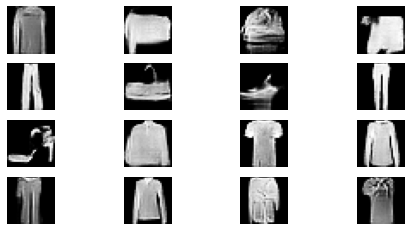

 22%|██▏       | 11/50 [02:43<09:38, 14.83s/it]

Time for epoch 11 is 14.720996141433716 sec
Training started with  epoch 12 with 1875 batches..
Losses after epoch    12: generator 0.944, discriminator 1.314, real_score 51.57%, fake_score 41.88%


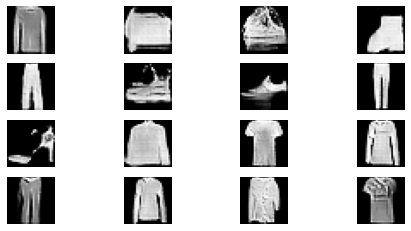

 24%|██▍       | 12/50 [02:58<09:23, 14.83s/it]

Time for epoch 12 is 14.804346561431885 sec
Training started with  epoch 13 with 1875 batches..
Losses after epoch    13: generator 0.913, discriminator 1.141, real_score 57.49%, fake_score 41.72%


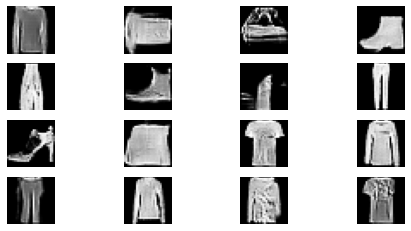

 26%|██▌       | 13/50 [03:13<09:10, 14.88s/it]

Time for epoch 13 is 15.015531539916992 sec
Training started with  epoch 14 with 1875 batches..
Losses after epoch    14: generator 0.773, discriminator 1.215, real_score 62.13%, fake_score 48.69%


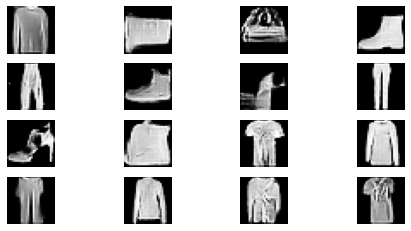

 28%|██▊       | 14/50 [03:28<08:54, 14.85s/it]

Time for epoch 14 is 14.763081550598145 sec
Training started with  epoch 15 with 1875 batches..
Losses after epoch    15: generator 0.895, discriminator 1.412, real_score 47.72%, fake_score 43.62%


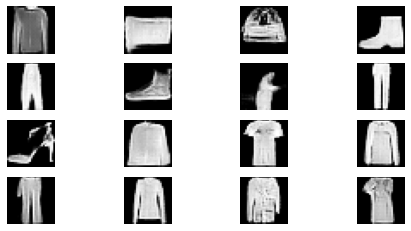

 30%|███       | 15/50 [03:43<08:38, 14.82s/it]

Time for epoch 15 is 14.736738681793213 sec
Training started with  epoch 16 with 1875 batches..
Losses after epoch    16: generator 0.714, discriminator 1.176, real_score 64.34%, fake_score 49.83%


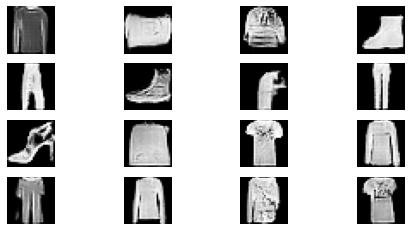

 32%|███▏      | 16/50 [03:58<08:24, 14.85s/it]

Time for epoch 16 is 14.9138925075531 sec
Training started with  epoch 17 with 1875 batches..
Losses after epoch    17: generator 0.651, discriminator 1.374, real_score 58.18%, fake_score 53.69%


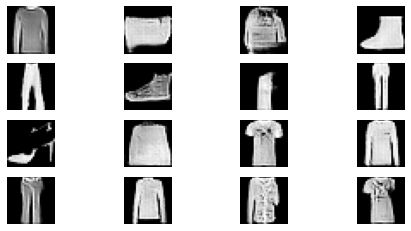

 34%|███▍      | 17/50 [04:12<08:09, 14.82s/it]

Time for epoch 17 is 14.757746934890747 sec
Training started with  epoch 18 with 1875 batches..
Losses after epoch    18: generator 0.858, discriminator 1.102, real_score 63.07%, fake_score 44.37%


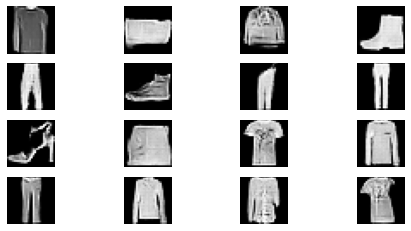

 36%|███▌      | 18/50 [04:27<07:53, 14.79s/it]

Time for epoch 18 is 14.714934349060059 sec
Training started with  epoch 19 with 1875 batches..
Losses after epoch    19: generator 0.852, discriminator 1.309, real_score 51.66%, fake_score 44.26%


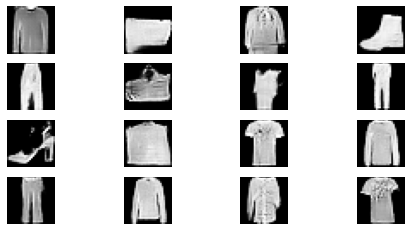

 38%|███▊      | 19/50 [04:42<07:38, 14.78s/it]

Time for epoch 19 is 14.737752437591553 sec
Training started with  epoch 20 with 1875 batches..
Losses after epoch    20: generator 0.797, discriminator 1.273, real_score 56.92%, fake_score 46.89%


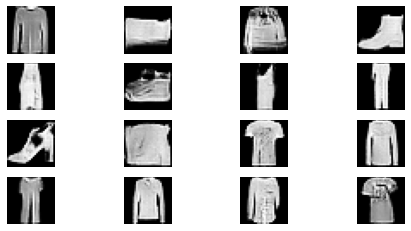

 40%|████      | 20/50 [04:57<07:26, 14.87s/it]

Time for epoch 20 is 15.073426485061646 sec
Training started with  epoch 21 with 1875 batches..
Losses after epoch    21: generator 0.864, discriminator 1.408, real_score 49.67%, fake_score 45.44%


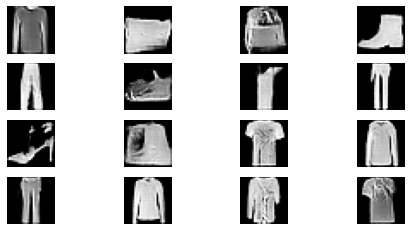

 42%|████▏     | 21/50 [05:12<07:10, 14.83s/it]

Time for epoch 21 is 14.753835201263428 sec
Training started with  epoch 22 with 1875 batches..
Losses after epoch    22: generator 0.860, discriminator 0.937, real_score 74.20%, fake_score 44.35%


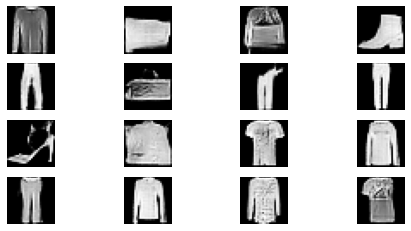

 44%|████▍     | 22/50 [05:26<06:54, 14.82s/it]

Time for epoch 22 is 14.773722410202026 sec
Training started with  epoch 23 with 1875 batches..
Losses after epoch    23: generator 0.803, discriminator 1.268, real_score 56.90%, fake_score 47.42%


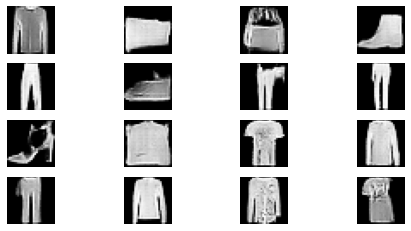

 46%|████▌     | 23/50 [05:41<06:39, 14.80s/it]

Time for epoch 23 is 14.767426252365112 sec
Training started with  epoch 24 with 1875 batches..
Losses after epoch    24: generator 0.748, discriminator 1.255, real_score 59.70%, fake_score 48.99%


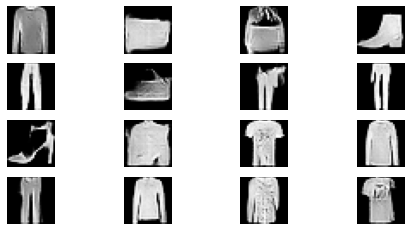

 48%|████▊     | 24/50 [05:56<06:26, 14.85s/it]

Time for epoch 24 is 14.957681655883789 sec
Training started with  epoch 25 with 1875 batches..
Losses after epoch    25: generator 0.769, discriminator 1.369, real_score 51.21%, fake_score 47.51%


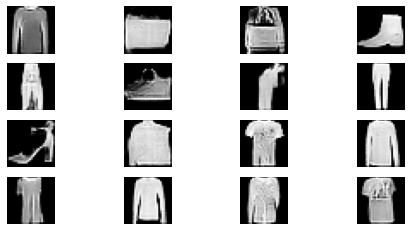

 50%|█████     | 25/50 [06:11<06:10, 14.83s/it]

Time for epoch 25 is 14.760921001434326 sec
Training started with  epoch 26 with 1875 batches..
Losses after epoch    26: generator 0.657, discriminator 1.402, real_score 57.01%, fake_score 53.39%


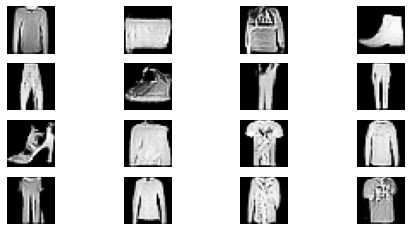

 52%|█████▏    | 26/50 [06:26<05:55, 14.81s/it]

Time for epoch 26 is 14.748815298080444 sec
Training started with  epoch 27 with 1875 batches..
Losses after epoch    27: generator 0.751, discriminator 1.314, real_score 56.00%, fake_score 48.86%


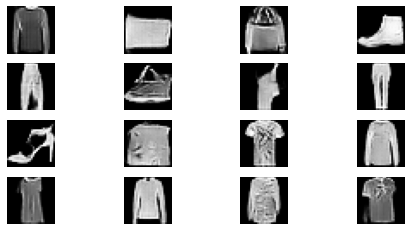

 54%|█████▍    | 27/50 [06:41<05:41, 14.85s/it]

Time for epoch 27 is 14.933856010437012 sec
Training started with  epoch 28 with 1875 batches..
Losses after epoch    28: generator 0.791, discriminator 1.386, real_score 49.56%, fake_score 46.29%


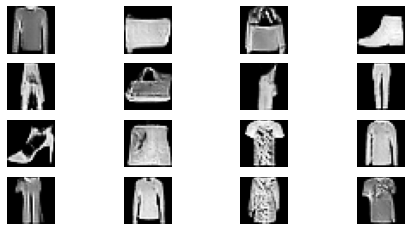

 56%|█████▌    | 28/50 [06:55<05:26, 14.82s/it]

Time for epoch 28 is 14.753148555755615 sec
Training started with  epoch 29 with 1875 batches..
Losses after epoch    29: generator 0.927, discriminator 1.245, real_score 53.97%, fake_score 41.80%


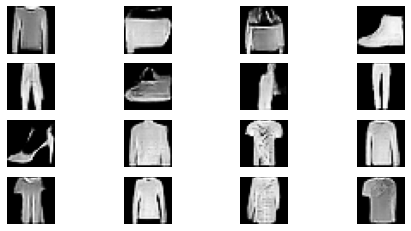

 58%|█████▊    | 29/50 [07:10<05:10, 14.80s/it]

Time for epoch 29 is 14.749955892562866 sec
Training started with  epoch 30 with 1875 batches..
Losses after epoch    30: generator 0.871, discriminator 1.296, real_score 50.91%, fake_score 43.21%


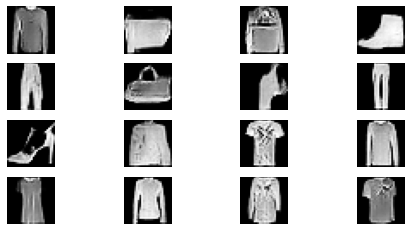

 60%|██████    | 30/50 [07:25<04:56, 14.83s/it]

Time for epoch 30 is 14.900935888290405 sec
Training started with  epoch 31 with 1875 batches..
Losses after epoch    31: generator 0.724, discriminator 1.420, real_score 52.92%, fake_score 50.72%


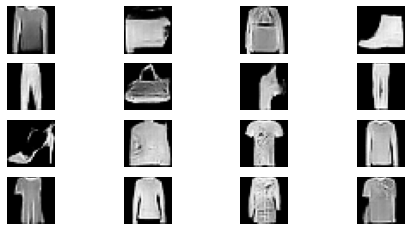

 62%|██████▏   | 31/50 [07:40<04:42, 14.89s/it]

Time for epoch 31 is 15.012157201766968 sec
Training started with  epoch 32 with 1875 batches..
Losses after epoch    32: generator 0.922, discriminator 1.356, real_score 48.85%, fake_score 42.44%


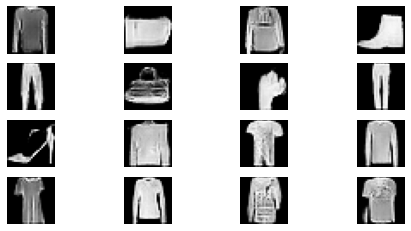

 64%|██████▍   | 32/50 [07:55<04:27, 14.86s/it]

Time for epoch 32 is 14.782589197158813 sec
Training started with  epoch 33 with 1875 batches..
Losses after epoch    33: generator 0.729, discriminator 1.459, real_score 49.48%, fake_score 49.45%


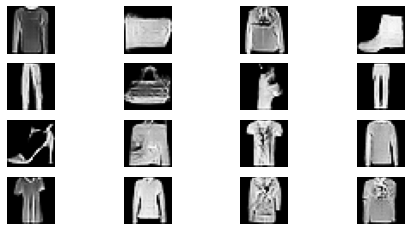

 66%|██████▌   | 33/50 [08:10<04:12, 14.85s/it]

Time for epoch 33 is 14.840915203094482 sec
Training started with  epoch 34 with 1875 batches..
Losses after epoch    34: generator 0.829, discriminator 1.491, real_score 44.75%, fake_score 45.25%


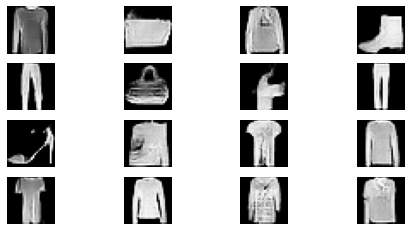

 68%|██████▊   | 34/50 [08:24<03:57, 14.84s/it]

Time for epoch 34 is 14.782840728759766 sec
Training started with  epoch 35 with 1875 batches..
Losses after epoch    35: generator 0.786, discriminator 1.335, real_score 54.28%, fake_score 47.88%


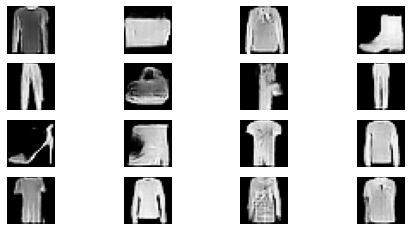

 70%|███████   | 35/50 [08:39<03:43, 14.88s/it]

Time for epoch 35 is 14.973941564559937 sec
Training started with  epoch 36 with 1875 batches..
Losses after epoch    36: generator 0.795, discriminator 1.365, real_score 53.75%, fake_score 47.68%


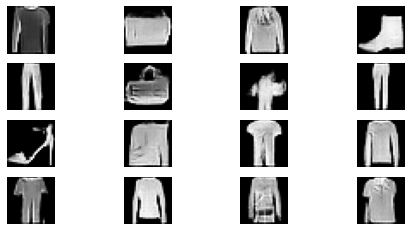

 72%|███████▏  | 36/50 [08:54<03:28, 14.86s/it]

Time for epoch 36 is 14.802335977554321 sec
Training started with  epoch 37 with 1875 batches..
Losses after epoch    37: generator 0.883, discriminator 1.255, real_score 54.33%, fake_score 43.07%


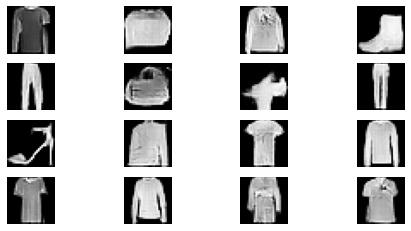

 74%|███████▍  | 37/50 [09:09<03:12, 14.83s/it]

Time for epoch 37 is 14.75632381439209 sec
Training started with  epoch 38 with 1875 batches..
Losses after epoch    38: generator 0.572, discriminator 1.361, real_score 65.75%, fake_score 58.02%


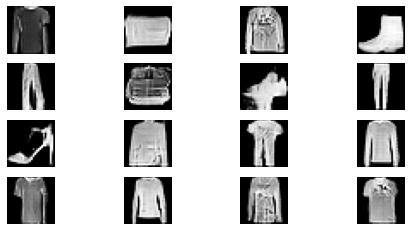

 76%|███████▌  | 38/50 [09:24<02:58, 14.89s/it]

Time for epoch 38 is 15.008815050125122 sec
Training started with  epoch 39 with 1875 batches..
Losses after epoch    39: generator 1.067, discriminator 1.097, real_score 54.92%, fake_score 36.18%


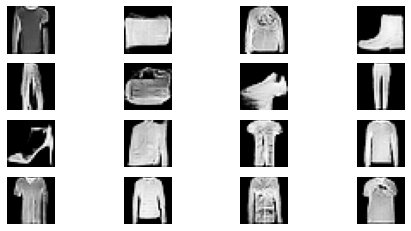

 78%|███████▊  | 39/50 [09:39<02:43, 14.85s/it]

Time for epoch 39 is 14.762370586395264 sec
Training started with  epoch 40 with 1875 batches..
Losses after epoch    40: generator 0.642, discriminator 1.549, real_score 53.81%, fake_score 55.59%


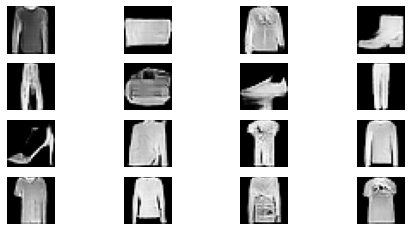

 80%|████████  | 40/50 [09:54<02:28, 14.86s/it]

Time for epoch 40 is 14.872279167175293 sec
Training started with  epoch 41 with 1875 batches..
Losses after epoch    41: generator 1.027, discriminator 1.073, real_score 59.45%, fake_score 37.84%


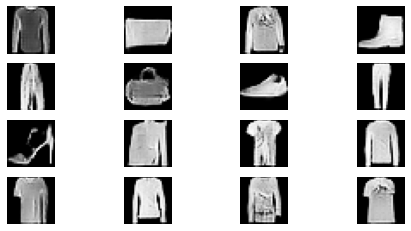

 82%|████████▏ | 41/50 [10:08<02:13, 14.83s/it]

Time for epoch 41 is 14.750289678573608 sec
Training started with  epoch 42 with 1875 batches..
Losses after epoch    42: generator 0.836, discriminator 1.163, real_score 61.24%, fake_score 45.47%


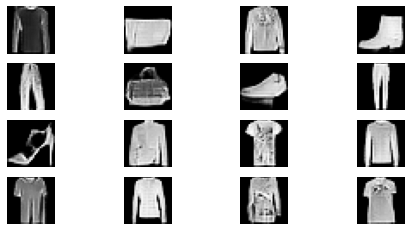

 84%|████████▍ | 42/50 [10:23<01:59, 14.88s/it]

Time for epoch 42 is 15.009463548660278 sec
Training started with  epoch 43 with 1875 batches..
Losses after epoch    43: generator 0.662, discriminator 1.290, real_score 62.81%, fake_score 53.05%


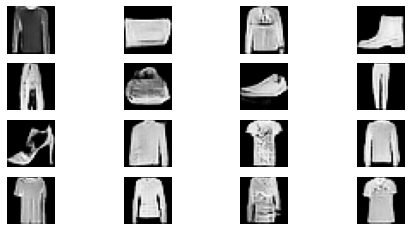

 86%|████████▌ | 43/50 [10:38<01:43, 14.85s/it]

Time for epoch 43 is 14.766491651535034 sec
Training started with  epoch 44 with 1875 batches..
Losses after epoch    44: generator 0.755, discriminator 1.165, real_score 64.99%, fake_score 49.37%


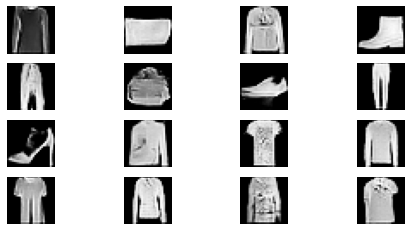

 88%|████████▊ | 44/50 [10:53<01:28, 14.82s/it]

Time for epoch 44 is 14.755948305130005 sec
Training started with  epoch 45 with 1875 batches..
Losses after epoch    45: generator 0.985, discriminator 1.328, real_score 47.37%, fake_score 40.40%


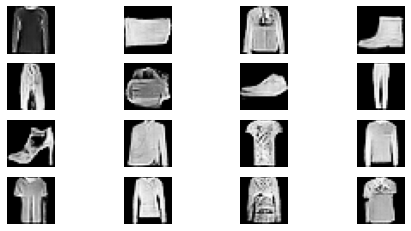

 90%|█████████ | 45/50 [11:08<01:14, 14.86s/it]

Time for epoch 45 is 14.951544046401978 sec
Training started with  epoch 46 with 1875 batches..
Losses after epoch    46: generator 0.706, discriminator 1.340, real_score 60.15%, fake_score 52.50%


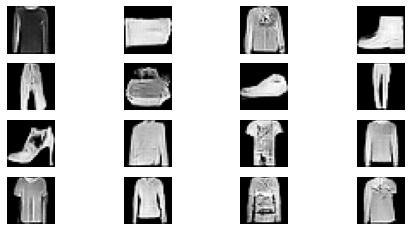

 92%|█████████▏| 46/50 [11:23<00:59, 14.84s/it]

Time for epoch 46 is 14.764297485351562 sec
Training started with  epoch 47 with 1875 batches..
Losses after epoch    47: generator 0.797, discriminator 1.370, real_score 50.89%, fake_score 46.98%


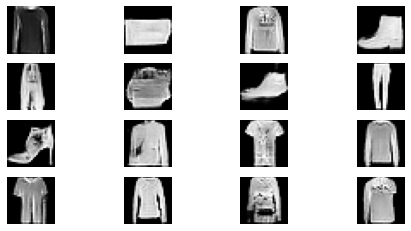

 94%|█████████▍| 47/50 [11:38<00:44, 14.82s/it]

Time for epoch 47 is 14.764806032180786 sec
Training started with  epoch 48 with 1875 batches..
Losses after epoch    48: generator 0.810, discriminator 1.256, real_score 56.59%, fake_score 46.10%


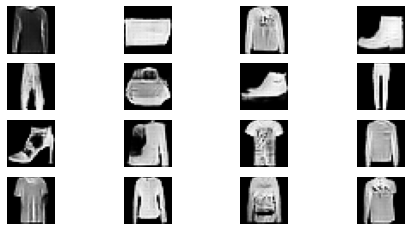

 96%|█████████▌| 48/50 [11:52<00:29, 14.81s/it]

Time for epoch 48 is 14.779629707336426 sec
Training started with  epoch 49 with 1875 batches..
Losses after epoch    49: generator 0.922, discriminator 1.220, real_score 53.22%, fake_score 41.55%


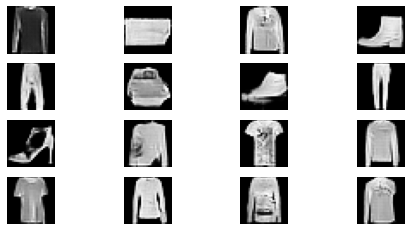

 98%|█████████▊| 49/50 [12:07<00:14, 14.88s/it]

Time for epoch 49 is 15.036255598068237 sec
Training started with  epoch 50 with 1875 batches..
Losses after epoch    50: generator 0.755, discriminator 1.223, real_score 60.72%, fake_score 48.41%


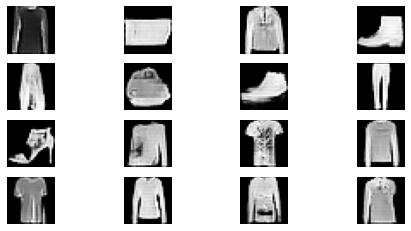

100%|██████████| 50/50 [12:22<00:00, 14.86s/it]

Time for epoch 50 is 14.893630266189575 sec


In [23]:
gen_loss_epochs, disc_loss_epochs,real_score_list,fake_score_list = train(train_dataset, epochs = epochs)

Real and fake scores both converge towards 0.5. This means that the discriminator is unable to differentiate between real and fake images. It has a 50% chance of getting classifications right (or wrong)

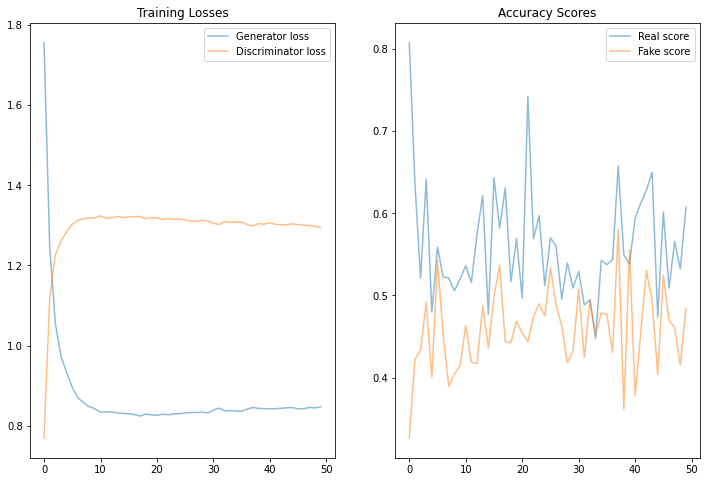

In [24]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12,8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()
ax1.set_title('Training Losses')
ax2.plot(real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()